# Face Recognition using Neural Net with ResNet-based architechure

This mini project solves the problem of face recognition.

[MTCNN](https://github.com/ipazc/mtcnn) was used to extrat faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).In this way new dataset with images containing only the faces has been created. Top 5 classes in terms of number of pictures has been choosen for training.

[ResNet architecture](https://arxiv.org/pdf/1512.03385.pdf) has been used for face recognition. At first stage ResNet34 has been applied, but it had to much parameters for this task which caused overfiting. Number of residual blocks has been decreased until overfiting didn't occur anymore. After that one block has been added, and small overfiting caused by that has been removed with  early stopping.

It is worth to notice that batch normalization increased neural net performance and ability to learn, and helped acomplished ~93.5% accuracy.

Training on the images returned by MTCNN has been really hard because of tight view on the face. Added margin of 10 pixels on each size gave the net more context and made it easier to learn.

Setting up the environment

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.7.0
Running on TPU  ['10.103.193.74:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.103.193.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.193.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Imports and functions

In [3]:
import copy
import os
import random
import numpy as np
import cv2 as cv
from tensorflow.keras.layers import Conv2D, Input, Lambda, Activation, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D, Add, AvgPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model


In [4]:
def one_hot(data, no_classes):
    res = np.zeros(shape=(len(data), no_classes)).astype(np.float32)
    for i in range(len(data)):
        res[i][data[i]] = 1.
    return res



Walking on the dataset directory and creating dictionary with classes that have more than 100 images.

In [6]:
dir_path = os.getcwd()
lfw_path = "/drive/MyDrive/lfw_faces_big"
root_cut_len = len(lfw_path)+9

people_dic = {}
for root, dirs, files in os.walk(dir_path+lfw_path, topdown=True):
  print(root[root_cut_len:])
  if len(files) >= 100:
      people_dic[root[root_cut_len:]] = len(files)
print(people_dic)
min_images = min(people_dic.items(), key=lambda o: o[1])[1]

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Turner_Gill
Tzipora_Obziler
Tyra_Banks
T_Boone_Pickens
Tyron_Garner
Ulrich_Kueperkoch
Tyrone_Medley
Uma_Thurman
Uday_Hussein
Ty_Votaw
Uri_Lopolianski
Valdas_Adamkus
Vaclav_Havel
Vadim_Devyatovskiy
Vaclav_Klaus
Vadim_Strogalev
Uzi_Even
Vagit_Alekperov
Urmila_Matondkar
Uthai_Pimchaichon
Uzi_Landau
Valentina_Cervi
Vanessa_Incontrada
Valentina_Tereshkova
Val_Ackerman
Valeri_Bure
Valerie_Harper
Valentino_Rossi
Valerie_Thwaites
Valery_Giscard_dEstaing
Valorie_Brabazon
Vanessa_Laine
Vernon_Forrest
Veronica_Lake
Viara_Vike-Freiberga
Vecdi_Gonul
Vassilis_Xiros
Vanessa_Redgrave
Venus_Williams
Vanessa_Williams
Van_Hilley
Vicente_Fox
Victor_Kraatz
Vicki_Zhao_Wei
Victor_Hanescu
Vidar_Helgesen
Vicente_Fox_de_la_Concha
Victor_Garber
Vicente_Fernandez
Victoria_Beckham
Victoria_Clarke
Viktor_Yushchenko
Vincent_Spadea
Vince_Carter
Vincent_Sombrotto
Vince_Dooley
Vince_Gill
Vincent_Brooks
Vincent_Cianci_Jr
Vijay_Nambiar
Vincent_Gallo
Vladimi

Loading and resizing images according to the dict from the last point.

In [7]:
people_X = []
people_y = []

IMG_HEIGHT = 128
IMG_WIDTH = 96
IMG_CHANNELS = 3
cnt = 0

for root, dirs, files in os.walk(dir_path+lfw_path, topdown=True):
    if root[root_cut_len:] in people_dic:
        inn_cnt = 0
        for f in files:
            print(f)
            if inn_cnt < min_images:
                img = cv.imread(os.path.join(root, f))
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                people_X.append(copy.copy(img))
                people_y.append(cnt)
                inn_cnt += 1
        cnt += 1
print('Data loaded')

Tony_Blair_0004.jpg
Tony_Blair_0001.jpg
Tony_Blair_0002.jpg
Tony_Blair_0005.jpg
Tony_Blair_0003.jpg
Tony_Blair_0006.jpg
Tony_Blair_0011.jpg
Tony_Blair_0016.jpg
Tony_Blair_0009.jpg
Tony_Blair_0015.jpg
Tony_Blair_0010.jpg
Tony_Blair_0017.jpg
Tony_Blair_0007.jpg
Tony_Blair_0013.jpg
Tony_Blair_0008.jpg
Tony_Blair_0014.jpg
Tony_Blair_0012.jpg
Tony_Blair_0024.jpg
Tony_Blair_0030.jpg
Tony_Blair_0028.jpg
Tony_Blair_0029.jpg
Tony_Blair_0021.jpg
Tony_Blair_0022.jpg
Tony_Blair_0023.jpg
Tony_Blair_0026.jpg
Tony_Blair_0025.jpg
Tony_Blair_0019.jpg
Tony_Blair_0027.jpg
Tony_Blair_0018.jpg
Tony_Blair_0020.jpg
Tony_Blair_0042.jpg
Tony_Blair_0038.jpg
Tony_Blair_0032.jpg
Tony_Blair_0039.jpg
Tony_Blair_0036.jpg
Tony_Blair_0043.jpg
Tony_Blair_0035.jpg
Tony_Blair_0031.jpg
Tony_Blair_0041.jpg
Tony_Blair_0040.jpg
Tony_Blair_0033.jpg
Tony_Blair_0037.jpg
Tony_Blair_0034.jpg
Tony_Blair_0047.jpg
Tony_Blair_0048.jpg
Tony_Blair_0057.jpg
Tony_Blair_0050.jpg
Tony_Blair_0045.jpg
Tony_Blair_0054.jpg
Tony_Blair_0049.jpg


Shuffling the data and randomly displaing to see if class numbers match pictures correctly.

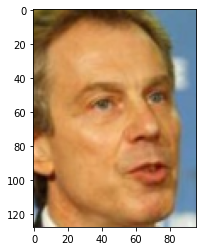

0


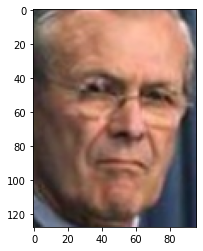

4


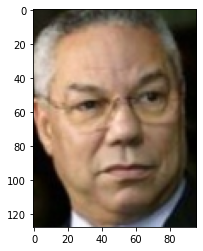

3


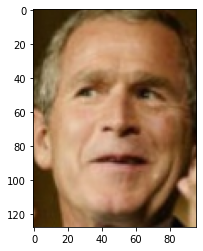

1


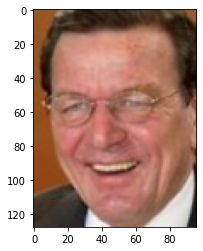

2


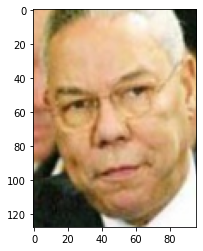

3


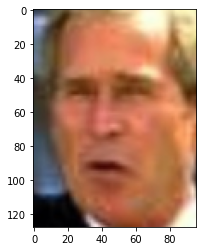

1


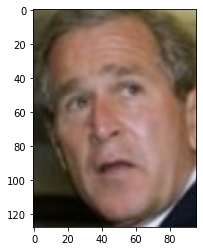

1


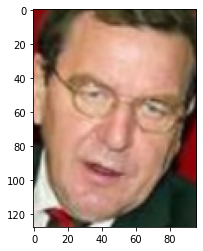

2


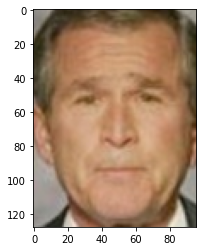

1


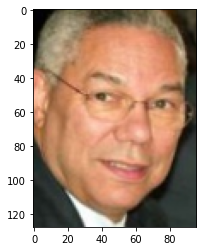

3


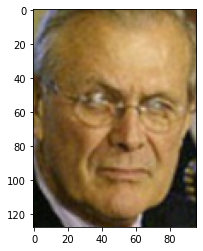

4


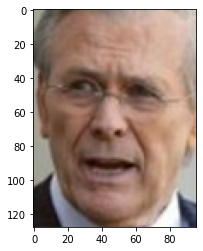

4


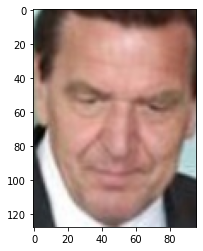

2


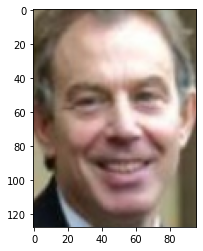

0


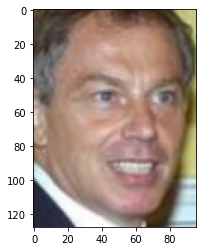

0


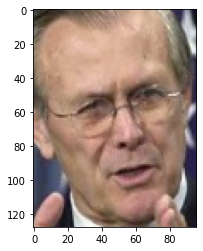

4


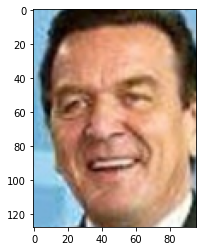

2


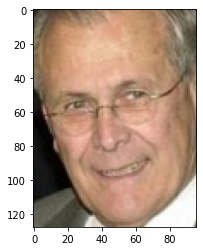

4


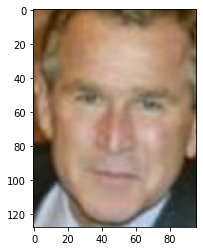

1


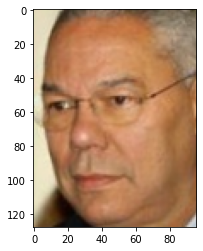

3


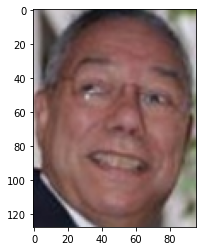

3


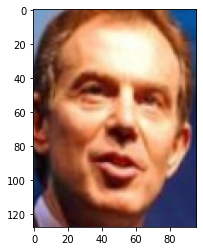

0


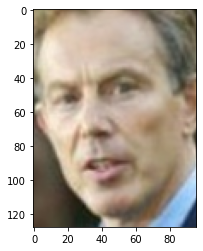

0


In [8]:
iterator = [i for i in range(len(people_X))]

random.shuffle(iterator)
X = []
y = []
for i in iterator:
    X.append(people_X[i])
    y.append(people_y[i])
    if random.randint(1, 100) < 5:
        plt.imshow(people_X[i])
        plt.show()
        print(people_y[i])



Augmenting the data by fliping images.

In [9]:
temp_X = X.copy()
for x in temp_X:
    X.append(cv.flip(x, 1))
y = y + y
print(len(y))

1090


Spliting into train/test sets.

In [10]:
X = np.array(X)
y = np.array(y)
y = one_hot(y, cnt)

TRAIN_TEST_RATIO = 0.9
train_X = X[:int(TRAIN_TEST_RATIO*len(X))]
train_y = y[:int(TRAIN_TEST_RATIO*len(X))]
test_X = X[int(TRAIN_TEST_RATIO*len(X)):]
test_y = y[int(TRAIN_TEST_RATIO*len(X)):]

print(train_X.shape)
print(test_X.shape)

(981, 128, 96, 3)
(109, 128, 96, 3)


Checking the distribution of the data.

(array([197.,   0., 195.,   0.,   0., 198.,   0., 193.,   0., 198.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

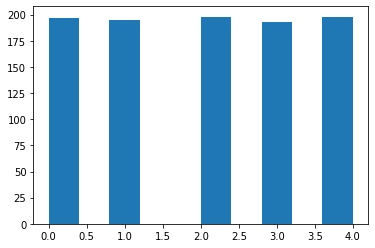

In [11]:
plt.hist([np.argmax(t) for t in train_y])

Checking the picture-class matching again.

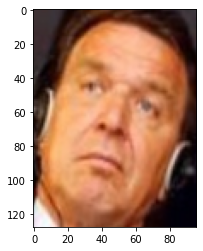

[0. 0. 1. 0. 0.]


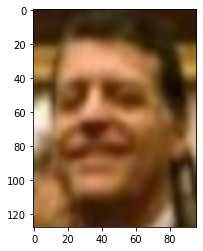

[0. 0. 0. 0. 1.]


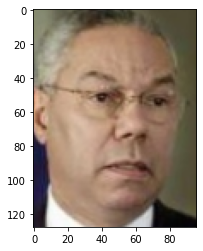

[0. 0. 0. 1. 0.]


In [12]:
for i in range(3):
    idx = random.randint(0, len(train_X))
    plt.imshow(train_X[idx])
    plt.show()
    print(train_y[idx])

Implementing ResNet block as a funciton.

In [14]:
def ResNetLayer(x,     
                filters,
                kernel_size,
                strides=(1, 1),
                padding="same",
                data_format='channels_last',
                dilation_rate=(1, 1),
                groups=1,
                activation=None,
                use_bias=True,
                kernel_initializer="glorot_uniform",
                bias_initializer="zeros",
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None,
                **kwargs):
    print(f'x: {x.shape}')
    conv1 = Conv2D(filters=filters,
                kernel_size=kernel_size,
                strides=strides,
                padding=padding,
                data_format=data_format,
                dilation_rate=dilation_rate,
                groups=groups,
                use_bias=use_bias,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                kernel_regularizer=kernel_regularizer,
                bias_regularizer=bias_regularizer,
                activity_regularizer=activity_regularizer,
                kernel_constraint=kernel_constraint,
                bias_constraint=bias_constraint,
                **kwargs)(x)
    print(f'conv1: {conv1.shape}')
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    print(f'act1: {act1.shape}')
    conv2 = Conv2D(filters=filters,
                kernel_size=kernel_size,
                strides=strides,
                padding=padding,
                data_format=data_format,
                dilation_rate=dilation_rate,
                groups=groups,
                use_bias=use_bias,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                kernel_regularizer=kernel_regularizer,
                bias_regularizer=bias_regularizer,
                activity_regularizer=activity_regularizer,
                kernel_constraint=kernel_constraint,
                bias_constraint=bias_constraint,
                **kwargs)(act1)
    print(f'conv2: {conv2.shape}')
    bn2 = BatchNormalization()(conv2)
    added = Add()([x, bn2])
    print(f'add: {added.shape}')
    output = Activation('relu')(added)
    print(f'out: {output.shape}')
    return output
    
    

Creating a net and training it.

In [33]:
## -------------------------------RESNET----------------------------------

random.seed(42)

with tpu_strategy.scope():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    
    conv_1 = Conv2D(64, kernel_size=3, padding='same')(s)    
    layer1 = ResNetLayer(conv_1, filters=64, kernel_size=3, padding='same')
    layer2 = ResNetLayer(layer1, filters=64, kernel_size=3, padding='same')
    layer3 = ResNetLayer(layer2, filters=64, kernel_size=3, padding='same')

    conv_2 = Conv2D(128, kernel_size=3, strides=(2,2), padding='same')(layer3)
    layer4 = ResNetLayer(conv_2, filters=128, kernel_size=3, padding='same')
    layer5 = ResNetLayer(layer4, filters=128, kernel_size=3, padding='same')

    conv_3 = Conv2D(256, kernel_size=3, strides=(2,2), padding='same')(layer5)
    layer7 = ResNetLayer(conv_3, filters=256, kernel_size=3)
    layer8 = ResNetLayer(layer7, filters=256, kernel_size=3)

    pool = AvgPool2D()(layer8)
    flat = Flatten()(pool)
    dense_1 = Dense(64)(flat)
    act_3 = Activation('relu')(dense_1)
    dense_2 = Dense(cnt)(act_3)
    outputs = Activation('softmax')(dense_2)

    model = Model(inputs=[inputs], outputs=[outputs])
    opt = SGD(learning_rate=0.01, momentum=0.0)
    schedule = LearningRateScheduler(scheduler)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=25, restore_best_weights=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(train_X, train_y, epochs=500, validation_split=0.1, batch_size=64, callbacks=[early_stop])

x: (None, 128, 96, 64)
conv1: (None, 128, 96, 64)
act1: (None, 128, 96, 64)
conv2: (None, 128, 96, 64)
add: (None, 128, 96, 64)
out: (None, 128, 96, 64)
x: (None, 128, 96, 64)
conv1: (None, 128, 96, 64)
act1: (None, 128, 96, 64)
conv2: (None, 128, 96, 64)
add: (None, 128, 96, 64)
out: (None, 128, 96, 64)
x: (None, 128, 96, 64)
conv1: (None, 128, 96, 64)
act1: (None, 128, 96, 64)
conv2: (None, 128, 96, 64)
add: (None, 128, 96, 64)
out: (None, 128, 96, 64)
x: (None, 64, 48, 128)
conv1: (None, 64, 48, 128)
act1: (None, 64, 48, 128)
conv2: (None, 64, 48, 128)
add: (None, 64, 48, 128)
out: (None, 64, 48, 128)
x: (None, 64, 48, 128)
conv1: (None, 64, 48, 128)
act1: (None, 64, 48, 128)
conv2: (None, 64, 48, 128)
add: (None, 64, 48, 128)
out: (None, 64, 48, 128)
x: (None, 32, 24, 256)
conv1: (None, 32, 24, 256)
act1: (None, 32, 24, 256)
conv2: (None, 32, 24, 256)
add: (None, 32, 24, 256)
out: (None, 32, 24, 256)
x: (None, 32, 24, 256)
conv1: (None, 32, 24, 256)
act1: (None, 32, 24, 256)
conv2:

Plotting the model.

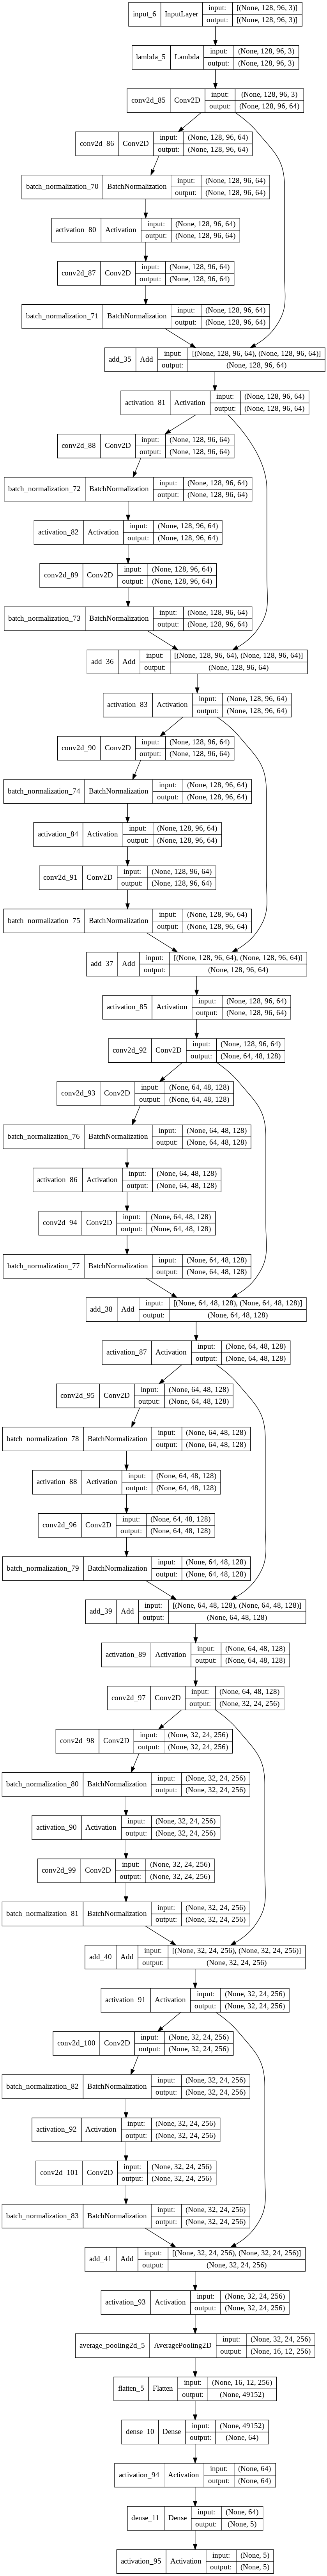

In [34]:
plot_model(model, show_shapes=True)

Plotting history of training.

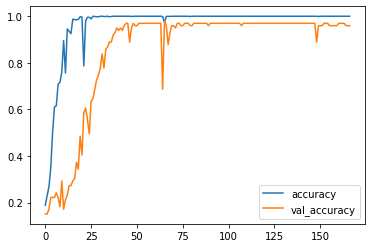

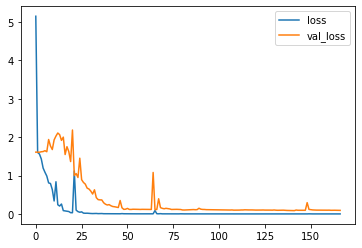

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Collecting predictions on test dataset.

In [36]:
pred = []
truth = []
for tx, ty in zip(test_X, test_y):
  prediction = model.predict(np.reshape(tx, newshape=(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
  pred.append(np.argmax(prediction))
  truth.append(np.argmax(ty))

Measuring the performance with various metrics and results visualization.

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('acc: ', accuracy_score(truth, pred))
print('precision: ', precision_score(truth, pred, average='weighted'))
print('recall: ', recall_score(truth, pred, average='weighted'))
print('f1: ', f1_score(truth, pred, average='weighted'))

acc:  0.9357798165137615
precision:  0.9396414072898863
recall:  0.9357798165137615
f1:  0.9351488239408197


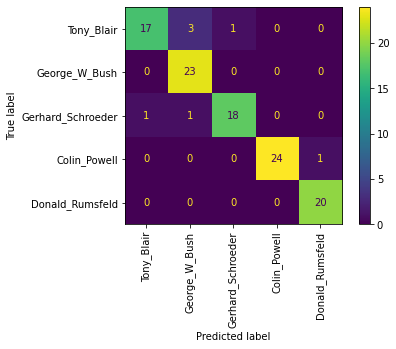

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

disp = ConfusionMatrixDisplay(confusion_matrix(truth, pred), display_labels=people_dic.keys())
disp.plot(xticks_rotation='vertical')